# Time-lapse Cameras

:::{admonition} Learning Objectives

**At the conclusion of this tutorial, you will...:**
- Know about all the time-lapse images available from the SnowEx 2017 and 2020 field campaigns 
- View example time-lapse images from SnowEx 2020 and visualize their locations
- Access snow depth measurements extracted from the SnowEx 2020 time-lapse images 
- Compare snow depths from different SnowEx 2020 time-lapse cameras 

:::

## Time-lapse Cameras on Grand Mesa during SnowEx Field Campaigns
Time-lapse cameras were installed in both the SnowEx 2017 and 2020 field campaigns on Grand Mesa in similar locations. 

**SnowEx 2017 Time-lapse Cameras** 
* 28 Total Time-lapse Cameras
* Capturing the entire winter season (September 2016-June 2017)
* Taking 4 photos/day at 8AM, 10AM, 12PM, 2PM, 4PM
* An orange pole was installed in front of 15 cameras for snow depth measurements
* Time-lapse images have been submitted to the NSIDC by Mark Raleigh with all the required metadata (e.g., locations, naming convention, etc.) for use. 

**SnowEx 2020 Time-lapse Cameras**
* 29 Total Time-lapse Cameras
* Capturing the entire winter season (September 2019-June 2020)
* Taking 3 photos/day at 11AM, 12PM, 1PM or 2 photos/day at 11AM and 12PM
* A red pole was installed in front of each camera for snow depth measurements.
* Cameras were installed on the east and west side of the Grand Mesa, across a vegetation scale of 1-9, using the convention __XMR__:
    * **X** = East (E) or West (W) areas of the Mesa
    * **M** = number 1-9, representing 1 (least vegetation) to 9 (most vegetation). Within each vegetation class, there were three sub-classes of snow depths derived from 2017 SnowEx lidar measurements. 
    * **R** = Replicate of vegetation assignment, either A, B, C, D, or E. 

### An automated way of viewing and mapping time-lapse photos

First, we will procedurally import the necessary packages to access the data. To access the snow depths at each camera station, we will use the SnowEx database (`snowexsql`) to access the depths as `PointMeasurements`.

In [ ]:
from snowexsql.api import PointMeasurements

# Import information for all point measurement types
measurements = PointMeasurements()

# List unique instruments
results = measurements.all_instruments
print('\nAvailable Instruments = {}'.format(', '.join([str(r) for r in results])))

In [ ]:
# Packages for data analysis 
import geopandas as gpd # geopandas library for data analysis and visualization
import pandas as pd # pandas as to read csv data and visualize tabular data
import numpy as np # numpy for data analysis 

# Packages for data visualization
import matplotlib mpl
import matplotlib.pyplot as plt # matplotlib.pyplot for plotting images and graphs

plt.rcParams['figure.figsize']  = (10, 4) # figure size
plt.rcParams['axes.titlesize']  = 14 # title size 
plt.rcParams['axes.labelsize']  = 12 # axes label size 
plt.rcParams['xtick.labelsize'] = 11 # x tick label size 
plt.rcParams['ytick.labelsize'] = 11 # y tick label size 
plt.rcParams['legend.fontsize'] = 11 # legend size 
mpl.rcParams['figure.dpi'] = 100

In [ ]:
# Query the database for camera-based snow depths
camera_depths = measurements.from_filter(
    type="depth",
    site_name="Grand Mesa",
    instrument="camera",
    limit = 13371
)

camera_depths.head()

#### Plot the camera locations, using snow pit locations for reference.

In [ ]:
camera_depths.explore(tooltip=['equipment','date','latitude','longitude','value','type','units'])

## Viewing the time-lapse photos
Thanks to the SnowEx database, we were able to easily access snow depths at each site. However, if we wish to examine the camera imagery, we will need to be a bit more creative.

The images are available through NSIDC, so we will use `earthaccess` to grab one of the image archives.

In [3]:
import earthaccess

# Authenticate with Earthdata Login servers
auth = earthaccess.login(strategy="interactive")

# Search for camera imagery
results = earthaccess.search_data(
    doi = "10.5067/WYRNU50R9L5R"
)

In [4]:
# Load the files into memory
files = earthaccess.open(results)

In [ ]:
results[0].data_links()

Looking at the above data links, one will notice that the images are saved in `.tar.gz` format. We can read files through `earthaccess` in this format, but it will require some more work than simply downloading the data.

Users may download the files if they wish, but they are on the larger side (900+ Mb). If you wish to avoid large data downloads, then the below code will help with the process. However, be aware that said code can be rather memory intensive. If running this code on CryoCloud, then consider using larger memory allocations (4+ Gb).

In [5]:
# Read the tar/gz files into memory
file_content = files[0].read()

IndexError: list index out of range

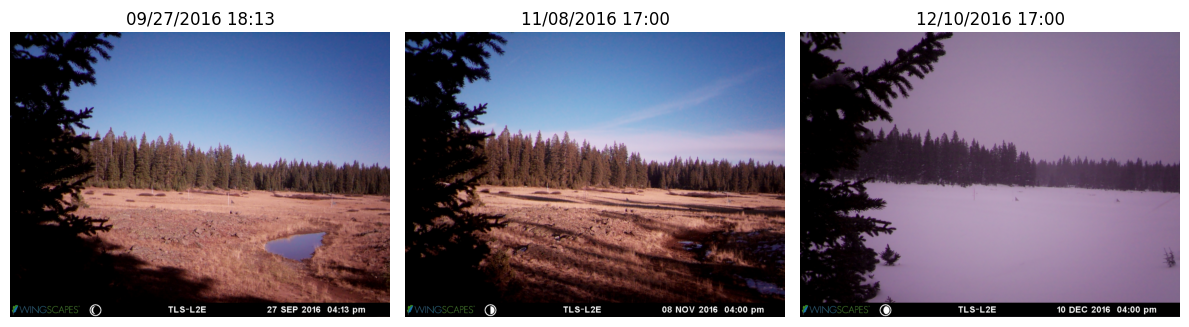

In [19]:
import tarfile
from io import BytesIO
from datetime import datetime
from PIL import Image
import matplotlib.pyplot as plt

jpg_files = []
# Open the tarfile remotely
with tarfile.open(fileobj=BytesIO(file_content), mode="r:gz") as tar:
    # Identify contents of tarfile
    members = tar.getmembers()

    # Loop through tarfile contents for images of interest
    fig, ax = plt.subplots(1,3, figsize=(12,12))
    ax.flatten()
    for member in members:
        if member.name.lower().endswith('.jpg'):
            jpg_file = tar.extractfile(member).read()
            
            # Estimate datetime from image
            creationTime = member.mtime
            dt_c = datetime.fromtimestamp(creationTime)
            formatted_datetime = dt_c.strftime("%m/%d/%Y %H:%M")

            desired_datetimes = ['09/27/2016 18:13',
                                 '11/08/2016 17:00',
                                 '12/10/2016 17:00']
            
            # Append files with desired datetime
            for idx,dt in enumerate(desired_datetimes):
                if formatted_datetime == dt:
                    image = Image.open(BytesIO(jpg_file))
                    ax[idx].imshow(image)
                    ax[idx].set_title(desired_datetimes[idx])
                    ax[idx].axis('off')

    plt.tight_layout()

In [14]:
len(jpg_files)

3

## Time-lapse Camera Applications

Installing snow poles in front of time-lapse camera provides low-cost, long-term snow depth timeseries. Snow depths from the 2020 SnowEx time-lapse imagery have been manually processed with estimation of submission to the NSIDC database in summer 2021. 

The snow depth is the difference between the number of pixels in a snow-free image and an image with snow, with a conversion from pixels to centimeters (**Figure 1**).

![equation](./images/time-lapse-camera/timelapse-camera-tutorial_27_0.png)

**Figure 1: Equation to extract snow depth from camera images. For each image, take the difference in pixels between the length of a snow-free stake and the length of the stake and multiply by length(cm)/pixel. The ratio can be found by dividing the full length of the stake (304.8 cm) by the length of a snow-free stake in pixels.**

Snow depth can be obtained in this manner manually, but it is now easier to determine the pixel size of the stakes through machine learning. For the sake of completeness, we will provide a brief example using the camera imagery above. Otherwise, users interested in using the camera imagery with machine learning are encouraged to check out the following resources by Katherine Breen and others:

**Publication on method**  
Breen C. M., W. R. Currier, C. Vuyovich, et al. 2024. "Snow Depth Extraction From Time‐Lapse Imagery Using a Keypoint Deep Learning Model." Water Resources Research 60 (7): [10.1029/2023wr036682]

**Github page for algorithm**  
https://github.com/catherine-m-breen/snowpoles

In the example images above, we use the red pole in the fully snow-off and snow-on images for estimation.

For the snow-off image, the length of the red pole is **136 pixels**. If we assume that the pole is 304.8 cm in length, then each pixel is approximately **2.24 cm** in length.

For the snow-on image, the length of the red pole is **72 pixels**, much shorter than the snow-off length. So, there is a **~64 pixel** difference between the snow-on and snow-off lengths. Using the equation in Figure 1, we can calculate snow depth:

Depth = 2.24 * (136-72) = **143.36 cm**

*Acknowledgements: Anthony Arendt, Scott Henderson, Micah Johnson, Carrie Vuyovich, Ryan Currier, Megan Mason, Mark Raleigh*

**Additional References**\
Dickerson-Lange et al., 2017. *Snow disappearance timing is dominated by forest effects on snow accumulation in warm winter climates of the Pacific Northwest, United States.* Hydrological Processes. Vol 31, Issue 10. 13 February 2017. https://doi.org/10.1002/hyp.11144

Raleigh et al., 2013. *Approximating snow surface temperature from standard temperature and humidity data: New possibilities for snow model and remote sensing evaluation*. Water Resources Research. Vol 49, Issue 12. 07 November 2013.  https://doi.org/10.1002/2013WR013958